In [1]:
import torch
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from classes import *

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

/home/clustor/ma/n/np923/fem_neural_operator/firedrake/lib/python3.10/site-packages/pytools/persistent_dict.py:59: UserWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
def check_downsample(fs1, data1, fs2, data2, index=100):
    fig1, axes1 = plt.subplots()
    fig2, axes2 = plt.subplots()

    fd.plot(fd.Function(fs1, val=data1[index, 0, :], name="FS1 - a"), axes=axes1)
    fd.plot(fd.Function(fs2, val=data2[index, 0, :], name="FS2 - a"), axes=axes1)
    fd.plot(fd.Function(fs1, val=data1[index, 1, :], name="FS1 - u"), axes=axes2)
    fd.plot(fd.Function(fs2, val=data2[index, 1, :], name="FS2 - u"), axes=axes2)

    axes1.legend()
    axes1.grid()
    axes2.legend()
    axes2.grid()

    plt.show()

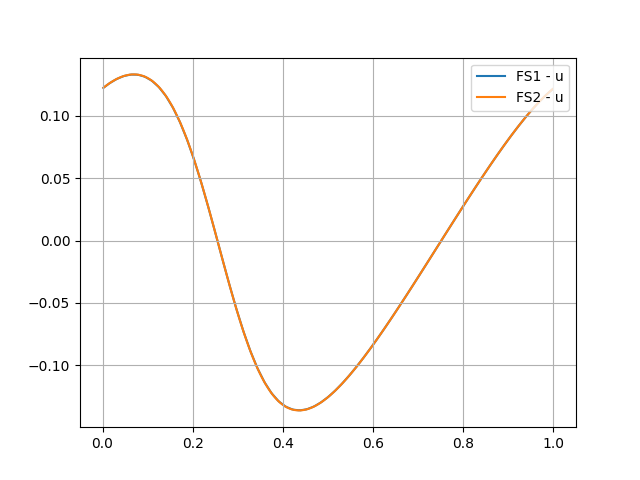

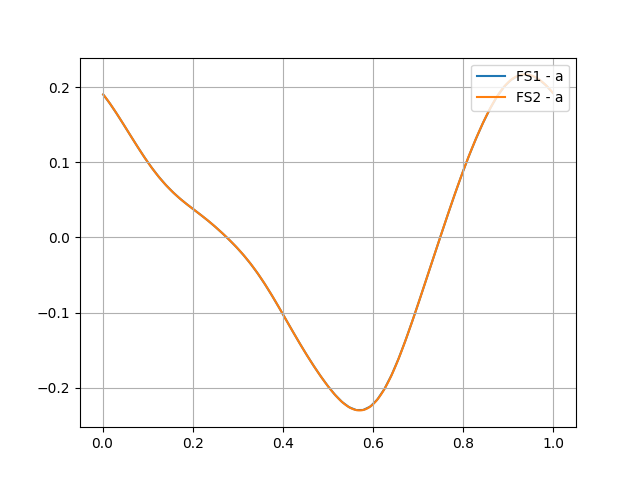

In [22]:
%matplotlib widget
N1 = 64
N2 = 1024

data1 = torch.load(f"data/burgers/samples/N{N1}_nu001_T1_samples1200.pt").numpy()
data2 = torch.load(f"data/burgers/samples/N{N2}_nu001_T1_samples1200.pt").numpy()

with fd.CheckpointFile(f"data/burgers/meshes/N{N1}.h5", "r") as file:
    fs1 = fd.FunctionSpace(file.load_mesh(), "CG", 1)

with fd.CheckpointFile(f"data/burgers/meshes/N{N2}.h5", "r") as file:
    fs2 = fd.FunctionSpace(file.load_mesh(), "CG", 1)

check_downsample(fs1, data1, fs2, data2)


In [2]:
N_domain = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
N_losses = []
for i, N in enumerate(N_domain):
    model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D64_M16_samples1000_epoch500.pt", N, "01", device)
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
    grid = torch.linspace(0, model.L, model.dof_count, device=device)
    trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
    testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
    
    mse_loss = nn.MSELoss(reduction="sum")
    loss = lambda x, y: mse_loss(x, y) / (N**2 * len(x))  # Sum of differences, times step size, divide by batch size
    mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1)/torch.norm(y, 2, dim=-1))
    optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
    
    network_trainer = NeuralNetworkTrainer(
        model,
        trainset,
        testset,
        mean_rel_l2_loss,
        optimizer,
        scheduler,
        max_epoch=500
    )
    
    N_losses.append(network_trainer.test_epoch().detach().cpu().numpy())
        

/tmp/ipykernel_1581322/2431459963.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_1581322/2431459963.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
/tmp/ipykernel_1581322/2431459963.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_1581322/2431459963.

[array(0.00187577, dtype=float32), array(0.00174894, dtype=float32), array(0.00133008, dtype=float32), array(0.00179511, dtype=float32), array(0.00162116, dtype=float32), array(0.00153801, dtype=float32), array(0.00142965, dtype=float32), array(0.00164739, dtype=float32)]


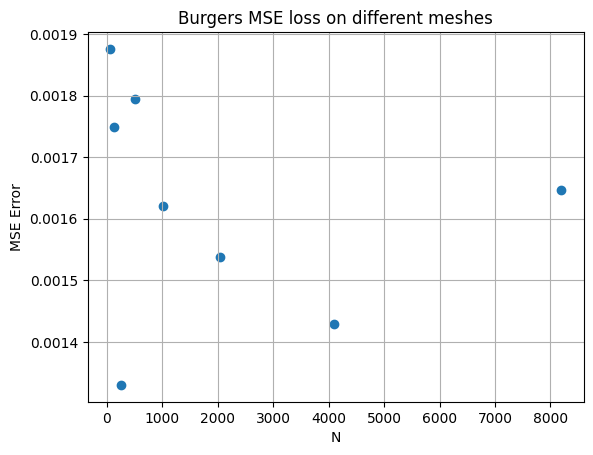

In [3]:
fig, axes = plt.subplots()
axes.scatter(N_domain, N_losses)
    
axes.set_xlabel("N")
axes.set_ylabel("MSE Error")
axes.set_title("Burgers MSE loss on different meshes")

axes.grid()
print(N_losses)

In [11]:
N = 8192
D_domain = [i * 10 for i in range(1, 7)]
M_domain = [1, 4, 8]
M_losses = {1: [], 4: [], 8: []}
for M in M_domain:
    for i, D in enumerate(D_domain):
        model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D{D}_M{M}_samples1000_epoch500.pt", N, "01", device)
        data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
        
        samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
        grid = torch.linspace(0, model.L, model.dof_count, device=device)
        trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
        testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
        
        mse_loss = nn.MSELoss(reduction="sum")
        loss = lambda x, y: mse_loss(x, y) /N  # Sum of differences, times step size, divide by batch size
        
        optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
        
        network_trainer = NeuralNetworkTrainer(
            model,
            trainset,
            testset,
            loss,
            optimizer,
            scheduler,
            max_epoch=500
        )
        
        M_losses[M].append(network_trainer.test_epoch().detach().cpu().numpy())
            

/tmp/ipykernel_3644789/3683626661.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_3644789/3683626661.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))


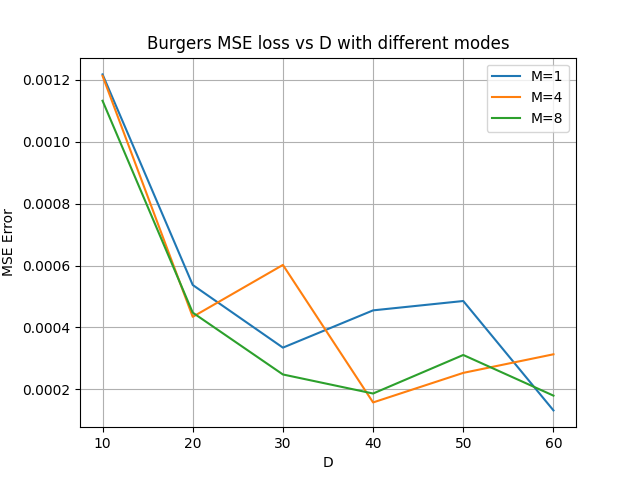

In [12]:
fig, axes = plt.subplots()

for M in M_losses.keys():
    axes.plot(D_domain, M_losses[M], label=f"M={M}")
    
axes.set_xlabel("D")
axes.set_ylabel("MSE Error")
axes.set_title("Burgers MSE loss vs D with different modes")
axes.legend()

axes.grid()

# Loss norm check across meshes

In [6]:
index = 50
N1 = 64
N2 = 1024

data1 = torch.load(f"data/burgers/samples/N{N1}_nu001_T1_samples1200.pt")
data2 = torch.load(f"data/burgers/samples/N{N2}_nu001_T1_samples1200.pt")

with fd.CheckpointFile(f"data/burgers/meshes/N{N1}.h5", "r") as file:
    mesh1 = file.load_mesh()
    fs1 = fd.FunctionSpace(mesh1, "CG", 1)

with fd.CheckpointFile(f"data/burgers/meshes/N{N2}.h5", "r") as file:
    mesh2 = file.load_mesh()
    fs2 = fd.FunctionSpace(mesh2, "CG", 1)
    

In [7]:
func_in_N1 = fd.Function(fs1, val=data1[index, 0, :])
func_out_N1 = fd.Function(fs1, val=data1[index, 1, :])

func_in_N2 = fd.Function(fs2, val=data2[index, 0, :])
func_out_N2 = fd.Function(fs2, val=data2[index, 1, :])

print(f"Errornorm N{N1}: {fd.errornorm(func_in_N1, func_out_N1)}")
print(f"Errornorm N{N2}: {fd.errornorm(func_in_N2, func_out_N2)}")


Errornorm N64: 0.20400927089329335
Errornorm N1024: 0.20425529433106604


In [8]:
mse_loss = torch.nn.MSELoss(reduction="sum")
loss_N1 = lambda x, y: torch.sqrt(mse_loss(x, y) / N1)
loss_N2 = lambda x, y: torch.sqrt(mse_loss(x, y) / N2)

In [9]:
coeff_in_N1 = data1[index, 0, :]
coeff_out_N1 = data1[index, 1, :]

coeff_in_N2 = data2[index, 0, :]
coeff_out_N2 = data2[index, 1, :]

In [10]:
print(f"Coefficient errornorm N{N1}: {loss_N1(coeff_in_N1, coeff_out_N1)}")
print(f"Coefficient errornorm N{N2}: {loss_N2(coeff_in_N2, coeff_out_N2)}")

Coefficient errornorm N64: 0.2042563110589981
Coefficient errornorm N1024: 0.20425626635551453


In [11]:
64 * (mesh1.coordinates.dat.data[4] - mesh1.coordinates.dat.data[5])

np.float64(-0.9999999999999996)

In [12]:
torch.sqrt(torch.sum(torch.square(coeff_in_N1 - coeff_out_N1))/N1)

tensor(0.2043)

In [13]:
N_losses = np.array([])
for i, N in enumerate(N_domain):
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"    
    samples = torch.load(data_path).to(device=device, dtype=torch.float64)[1000:]
    
    mse_loss = nn.MSELoss(reduction="sum")
    loss = lambda x, y: mse_loss(x, y) / (N * len(x))

    N_losses = np.append(N_losses, loss(samples[:, 0], samples[:, 1]).cpu().numpy())

NameError: name 'N_domain' is not defined

In [14]:
plt.plot(np.abs((N_losses- N_losses[-1])/N_losses[-1]))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [37]:
torch.sum(torch.square(data1[0, 0, :] - data1[0, 1, :]))/N1

tensor(0.0017)

In [38]:
torch.sum(torch.square(data2[0, 0, :] - data2[0, 1, :]))/N2

tensor(0.0017)

In [57]:
model2 = BurgersModel.load(f"data/burgers/models/fourier/N{N2}/T1/D{64}_M{16}_samples1000_epoch500.pt", N1, "01", device)

/home/clustor/ma/n/np923/fem_neural_operator/fem_neural_operator/classes/NeuralOperatorModel.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict, config = torch

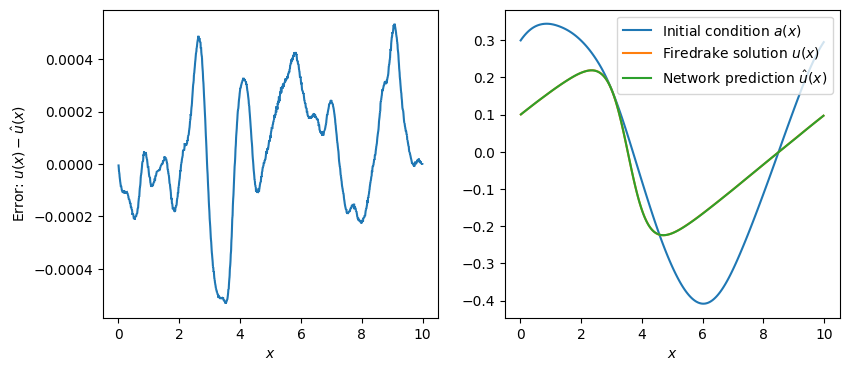

In [49]:
index = 90
N = 1024

model1 = BurgersModel.load(f"../../data/burgers/models/CG1/fourier/N{N}/T1/D{64}_M{16}_samples1000_epoch500.pt", N, "01", device)
fs1 = FunctionSpace(model1.mesh, "CG", 1)
 

samples1 = torch.load(f"../../data/burgers/samples/N{N}_nu001_T1_samples1200.pt" ).unsqueeze(2).to(device=device, dtype=torch.float32)
grid1 = torch.linspace(0, model1.L, model1.dof_count, device=device)
trainset1 = Dataset(torch.tensor(samples1[:model1.train_samples]), torch.tensor(grid1))
testset1 = Dataset(torch.tensor(samples1[model1.train_samples:]), torch.tensor(grid1))

predictions1 = model1.network(testset1.inputs)

fig, axes = plt.subplots(1, 2, figsize=(9.5, 4))

prediction = Function(fs1, val=predictions1[index, 0, :].detach().cpu().numpy(), name="Network prediction $\hat{u}(x)$")
solution = Function(fs1, val=testset1.targets[index, :].detach().cpu().numpy(), name="Firedrake solution $u(x)$")
diff = assemble(solution - prediction)

plot(diff, axes=axes[0], color="red")
plot(Function(fs1, val=testset1.inputs[index][0].detach().cpu().numpy(), name="Initial condition $a(x)$"), axes=axes[1])
plot(solution, axes=axes[1])
pred_plot = plot(prediction, axes=axes[1])

axes[0].set_xlabel("$x$")
axes[0].set_ylabel("Error: $u(x) - \hat{u}(x)$")

axes[1].set_xlabel("$x$")


axes[1].legend()

plt.savefig("Burgers example and error")

/tmp/ipykernel_468333/1657897017.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset2 = Dataset(torch.tensor(samples2[:model2.train_samples]), torch.tensor(grid2))
/tmp/ipykernel_468333/1657897017.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset2 = Dataset(torch.tensor(samples2[model2.train_samples:]), torch.tensor(grid2))


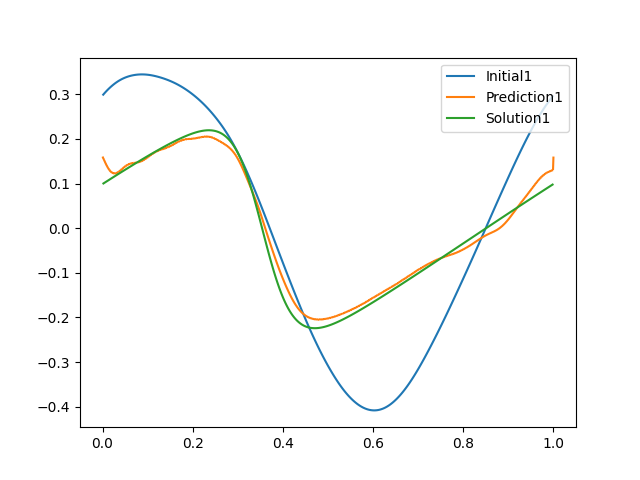

In [64]:
%matplotlib widget

index = 90

samples2 = data2.unsqueeze(2).to(device=device, dtype=torch.float32)
grid2 = torch.linspace(0, model2.L, model2.dof_count, device=device)
trainset2 = Dataset(torch.tensor(samples2[:model2.train_samples]), torch.tensor(grid2))
testset2 = Dataset(torch.tensor(samples2[model2.train_samples:]), torch.tensor(grid2))

predictions2 = model2.network(testset2.inputs)

fig, axes = plt.subplots()

fd.plot(fd.Function(fs2, val=testset2.inputs[index][0].detach().cpu().numpy(), name="Initial1"), axes=axes)
fd.plot(fd.Function(fs2, val=predictions2[index, 0, :].detach().cpu().numpy(), name="Prediction1"), axes=axes)
fd.plot(fd.Function(fs2, val=testset2.targets[index, :].detach().cpu().numpy(), name="Solution1"), axes=axes)
axes.legend()

In [16]:
print(model1.network(data1[:10].to(device=device, dtype=torch.float32)).shape)

test_network = NeuralOperatorNetwork(8, 10, 3, model1.projection)

torch.Size([10, 1, 64])


TypeError: NeuralOperatorNetwork.__init__() missing 1 required positional argument: 'projection'

In [56]:
modules = []
for m in test_network.modules():
    modules.append(m)


torch.Size([10, 10, 1])

In [57]:
modules[3][0].linear.weight.shape

torch.Size([10, 10, 1])

In [58]:
modules[3][0].linear.bias

Parameter containing:
tensor([-0.0039, -0.2471, -0.1370,  0.0751, -0.0233, -0.1280, -0.2508, -0.1274,
        -0.1436, -0.1730], requires_grad=True)

In [59]:
model1.named_modules()

AttributeError: 'BurgersModel' object has no attribute 'named_modules'

In [61]:
model1_modules = [m for m in model1.network.modules()]

In [65]:
model1_modules[3][0].weights.shape

torch.Size([17, 20, 20])

In [103]:
torch.sum(model1.projection.coeff[1])

tensor(4.2013e-18, device='cuda:3')

In [105]:
torch.sum(model2.projection.coeff[1]

tensor([-7.4359e-19,  1.1984e-05,  2.3968e-05,  ..., -3.5951e-05,
        -2.3968e-05, -1.1984e-05], device='cuda:3')

In [113]:
model1.projection.coeff.shape

torch.Size([17, 64])

In [114]:
test_network = NeuralOperatorNetwork(8, 10, 3, model1.projection)
modules[3]

NeuralOperatorLayer(
  (linear): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import firedrake as fd

class NeuralOperatorLayerTest(nn.Module):
    def __init__(
            self,
            N: int,
            M: int,
            D: int,
            projection,
            device: str
    ):
        """
        A network module that performs the interior layers operation in the Nonlocal Neural Operator architecture.
        This includes: Linear transformation with bias, preprojection linear transformation, projection to 'psi'
        functions (multiplication by coefficient), and nonlinearity.

        Args:
            M (int): Number of Fourier modes.
            D (int): Number of channels for fan-out.
            projection (ProjectionCoefficient): An instance of ProjectionCoefficient.
            device (str): Torch device to use ('cpu' or 'cuda').
        """
        super().__init__()

        self.coeff = projection.coeff
        self.coeff_T = projection.coeff.T

        # Linear matrix multiplication that mixes up the channels (W operator), also called MLP. It includes the bias.
        self.linear = nn.Conv1d(D, D, kernel_size=1, device=device)
        with torch.no_grad():
            self.linear.weight.data /= N
            self.linear.bias.data /= N
        
        self.weights = nn.Parameter(torch.rand(2 * M + 1, D, D, requires_grad=True, device=device))  # MxDxD parameters

    def forward(self, u):
        wu = self.linear(u)
        s = torch.einsum("mji, bim, mn -> bjn", self.weights, u @ self.coeff_T, self.coeff)
        
        return functional.gelu(wu + s) # Changed this to use s only!


In [192]:
from collections import defaultdict

# sums = defaultdict(list)

index = 10
N_domain = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

for i, N in enumerate(N_domain):
    model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D20_M8_samples1000_epoch500.pt", N, "01", device)
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)

    for _ in range(2000):
        network = NeuralOperatorLayerTest(N, 8, 10, model.projection, device)
        sample = samples[index, 0, :].repeat(10, 1).unsqueeze(0)

        sums[N].append(torch.sum(network(sample)))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU  has a total capacity of 23.68 GiB of which 5.00 MiB is free. Process 3859423 has 6.50 GiB memory in use. Process 3859718 has 6.50 GiB memory in use. Process 3944002 has 6.55 GiB memory in use. Including non-PyTorch memory, this process has 4.11 GiB memory in use. Of the allocated memory 3.68 GiB is allocated by PyTorch, and 128.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [193]:
for N in N_domain:
    print(f"N={N}, mean={np.mean([num.detach().cpu().numpy() for num in sums[N]])}")

N=64, mean=0.4716300070285797
N=128, mean=0.236656054854393
N=256, mean=0.12185897678136826
N=512, mean=0.05144990235567093
N=1024, mean=0.01612243242561817
N=2048, mean=0.011854448355734348
N=4096, mean=0.005207524169236422
N=8192, mean=0.012698839418590069


In [37]:
N_domain = [64, 128, 256, 512, 8192]
norms = []
mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1)/torch.norm(y, 2, dim=-1))

for i, N in enumerate(N_domain):
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
    print(f"N = {N}")
    norms.append(mean_rel_l2_loss(samples[:10, 0, ...], samples[-10:, 0, ...]))


N = 64
N = 128
N = 256
N = 512
N = 8192
tensor(0., device='cuda:2')


In [9]:
model1 = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D20_M8_samples1000_epoch500.pt", N, "01", device)
data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"


1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


# Fourier breakdown

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from burgers import BurgersDataset

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [6]:
N = 4096
data = torch.load(f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt")
inputs = data[:, 0, :]
targets = data[:, 1, :]

In [7]:
fft_result = torch.fft.fft(targets, dim=1)
# Compute the magnitude (absolute value) of the Fourier coefficients
magnitude = torch.abs(fft_result)
# Get the frequencies corresponding to the FFT result
# fftfreq generates the sample frequencies
frequencies = torch.fft.fftfreq(N, d=1/N)
# We only need the first half of the FFT output, since it's symmetric
# and we are dealing with real-valued functions
magnitude = magnitude[:, :N//2]
frequencies = frequencies[:N//2]

# Flatten the magnitudes to create a single histogram for all frequencies
flattened_magnitude = magnitude.flatten().numpy()

In [20]:
from typing import List

import torch
import matplotlib.pyplot as plt
import firedrake as fd

from burgers import BurgersDataset
from classes import NeuralOperatorNetwork, BurgersModel, ProjectionCoefficient, NeuralNetworkTrainer

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


def train_models(config, mode_arr):
    """
    Train models based on the given configuration and list of mode values.

    Args:
        config (dict): Configuration dictionary containing model and training parameters.
        mode_arr (List[int]): List of mode values for training.
    """

    for M in mode_arr:
        config["M"] = M
        model = BurgersModel(config["N"],
                             config["M"],
                             config["D"],
                             config["depth"],
                             config["T"],
                             config["projection_type"],
                             device=device)
        print(f"Training M={M}, D={config['D']} with param={model.param_num}")
        model.train(f"data/burgers/samples/N{config['N']}_nu001_T{config['T']}_samples1200.pt", config['epoch'],
                    lr=0.001, device=device)


def load_models(config, mode_arr):
    """
    Load trained models based on the given configuration and list of mode values.

    Args:
        config (dict): Configuration dictionary containing model and training parameters.
        mode_arr (List[int]): List of mode values for loading models.

    Returns:
        Tuple[List[NeuralOperatorModel], BurgersDataset]: List of loaded models and the dataset.
    """
    global device

    models = []
    for M in mode_arr:
        filename = f"data/burgers/models/{config['projection_type']}/N{config['N']}/T{config['T']}" \
                   f"/D{config['D']}_M{M}_samples{config['train_samples']}_epoch{config['epoch']}.pt"

        samples = (torch.load(f"data/burgers/samples/N{config['N']}_nu001_T{config['T']}_samples1200.pt")
                   .unsqueeze(2).to(device=device, dtype=torch.float32))
        grid = torch.linspace(0, 1, config['N'], device=device)
        dataset = BurgersDataset(samples, grid)

        models.append(BurgersModel.load(filename, config["N"], config["T"], device))

    return models, dataset[config["train_samples"]:]  # Cutting off the train data


def average_firedrake_loss(
        models: List[BurgersModel],
        dataset: BurgersDataset
) -> List[float]:
    """
    Calculate the average loss using Firedrake's errornorm for a list of models on a given dataset.

    Args:
        models (List[NeuralOperatorModel]): List of models to evaluate.
        dataset (BurgersDataset): Dataset to evaluate on.

    Returns:
        List[float]: List of average losses for each model.
    """
    targets = dataset[:][1].squeeze(1).detach().cpu().numpy()

    with fd.CheckpointFile(f"data/burgers/meshes/N{models[0].N}.h5", "r") as file:
        function_space = fd.FunctionSpace(file.load_mesh(), "CG", 1)

    losses = []
    for model in models:
        predictions = model.network(dataset[:][0]).squeeze(1).detach().cpu().numpy()

        loss = 0
        for target, predict in zip(targets, predictions):
            target_func = fd.Function(function_space, val=target)
            loss += fd.errornorm(
                target_func,
                fd.Function(function_space, val=predict),
                "L2"
            ) / fd.norm(target_func)

        losses.append(loss / len(targets))

    return losses


config = {
    "D": 64,
    "N": 4096,
    "depth": 1,
    "T": 1,
    "projection_type": "fourier",
    "loss_type": "MSE",
    "train_samples": 1000,
    "epoch": 500,
}

mode_arr = [i for i in range(0, 62, 2)]
losses = average_firedrake_loss(*load_models(config, mode_arr))

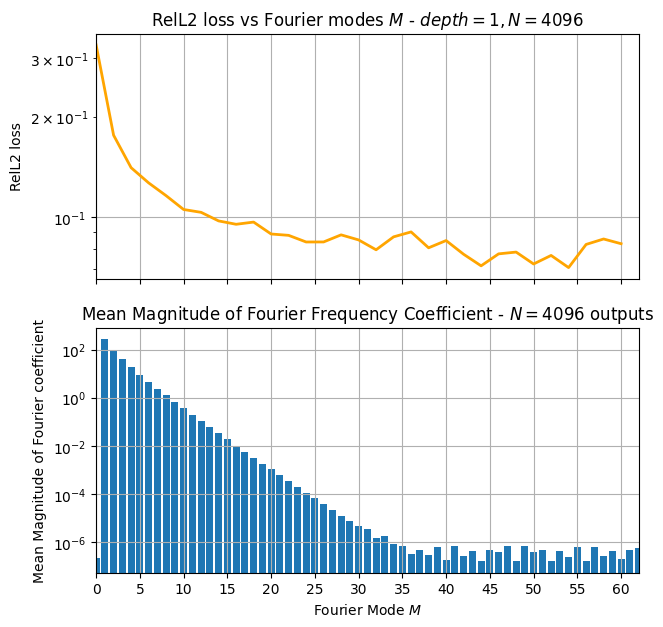

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

axes[1].set_xlim([0, 62])
axes[0].set_xlim([0, 62])

axes[0].plot(mode_arr, losses, color="orange", linewidth=2)
axes[0].set_yscale("log")
axes[0].set_ylabel('RelL2 loss')
axes[0].set_title("RelL2 loss vs Fourier modes $M$ - $depth=1, N=4096$")

axes[0].grid()




axes[1].bar(range(len(magnitude[0])), torch.mean(magnitude, dim=0))
axes[1].set_yscale("log")
axes[1].set_xticks(range(0, 61, 5));
axes[1].grid()
axes[1].set_xlabel('Fourier Mode $M$')
axes[1].set_ylabel('Mean Magnitude of Fourier coefficient')
axes[1].set_title('Mean Magnitude of Fourier Frequency Coefficient - $N=4096$ outputs')

plt.savefig("Burgers_depth1_loss_and_fcoeff_vs_modes")


---

In [12]:
from classes import BurgersModel
N = 4096

modes_sorted = {}
for M in range(8, 28, 2):
    model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D64_M{M}_samples1000_epoch500.pt", N, "01", device)
    
    norms1 = {}
    for mode, norm in enumerate(torch.sum(torch.abs(model.network.layers[0].weights), dim=[1, 2])):
        norms1[mode] = norm.detach().cpu().numpy()
    modes_sorted[M] = sorted(norms1, key=lambda x: norms1[x], reverse=True)

In [13]:
for M in modes_sorted:
    for i in 

{8: [16, 12, 14, 8, 10, 15, 11, 7, 2, 3, 4, 1, 6, 9, 13, 5, 0],
 10: [16,
  20,
  18,
  12,
  14,
  8,
  15,
  7,
  10,
  11,
  19,
  3,
  2,
  4,
  1,
  6,
  13,
  5,
  9,
  17,
  0],
 12: [20,
  24,
  22,
  16,
  12,
  18,
  14,
  8,
  23,
  15,
  11,
  10,
  19,
  3,
  7,
  2,
  4,
  1,
  17,
  9,
  5,
  21,
  13,
  6,
  0],
 14: [24,
  16,
  28,
  20,
  26,
  22,
  12,
  18,
  14,
  8,
  15,
  10,
  23,
  11,
  7,
  19,
  27,
  3,
  2,
  1,
  4,
  17,
  25,
  13,
  6,
  9,
  21,
  5,
  0],
 16: [24,
  32,
  28,
  20,
  30,
  16,
  26,
  18,
  22,
  14,
  12,
  31,
  11,
  23,
  8,
  19,
  15,
  27,
  10,
  3,
  7,
  2,
  4,
  1,
  25,
  5,
  6,
  21,
  17,
  13,
  29,
  9,
  0],
 18: [28,
  36,
  20,
  24,
  32,
  16,
  30,
  26,
  34,
  12,
  22,
  18,
  14,
  8,
  11,
  15,
  19,
  23,
  7,
  27,
  31,
  10,
  4,
  35,
  2,
  3,
  1,
  33,
  25,
  29,
  21,
  6,
  5,
  17,
  13,
  9,
  0],
 20: [32,
  24,
  16,
  40,
  36,
  34,
  38,
  30,
  28,
  20,
  26,
  22,
  18,
  12,
  1

In [55]:
from classes import BurgersModel
model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1_depth4/D64_M26_samples1000_epoch500.pt", N, "01", device)

norms2 = {}
for mode, norm in enumerate(torch.sum(torch.abs(model.network.layers[0].weights), dim=[1, 2])):
    norms2[mode] = norm.detach().cpu().numpy()

print(f"Sum of norms2 is {sum(norms2.values())}")
for i in sorted(norms2, key=lambda x: norms2[x], reverse=True):
    print(i, norms2[i])

Sum of norms2 is 6894.61865234375
16 362.75354
7 360.7951
23 317.56525
14 305.34528
18 269.03625
4 257.19476
6 250.517
8 226.35233
20 213.60358
10 193.04703
12 182.54456
22 162.6951
3 161.77014
5 161.23279
24 131.03291
39 127.75307
28 122.717285
1 120.99063
48 118.98932
2 116.28401
32 110.64151
26 103.8609
30 101.57466
46 96.96138
50 95.9715
52 94.25585
38 92.938416
47 92.85161
42 92.70624
9 88.6084
51 88.023926
44 87.7652
34 87.47757
31 86.24986
40 84.6048
27 82.91872
36 82.54134
43 82.25675
49 79.14418
45 78.34352
35 76.38837
15 76.262375
37 75.53166
19 73.87327
29 73.80413
33 72.80444
41 70.84428
25 70.418396
13 69.02375
17 67.58678
11 66.40509
21 65.07958
0 64.68025


<BarContainer object of 53 artists>

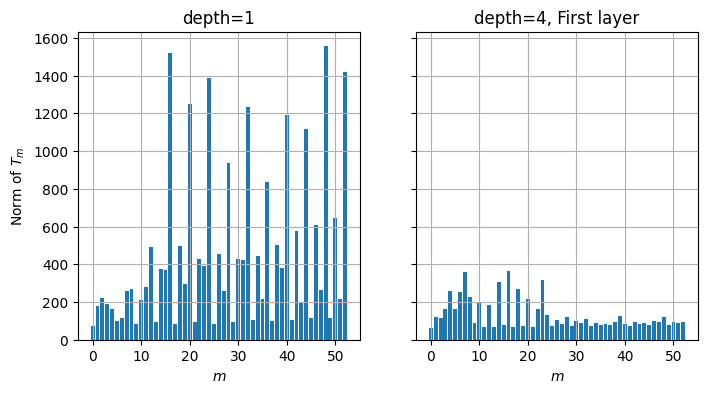

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, squeeze=True)
axes[1].set_title("depth=4, First layer")
axes[1].set_xlabel("$m$")
axes[1].grid()
axes[1].bar(norms2.keys(), norms2.values())

axes[0].set_title("depth=1")
axes[0].set_ylabel("Norm of $T_m$")
axes[0].set_xlabel("$m$")
axes[0].grid()
axes[0].bar(norms1.keys(), norms1.values())

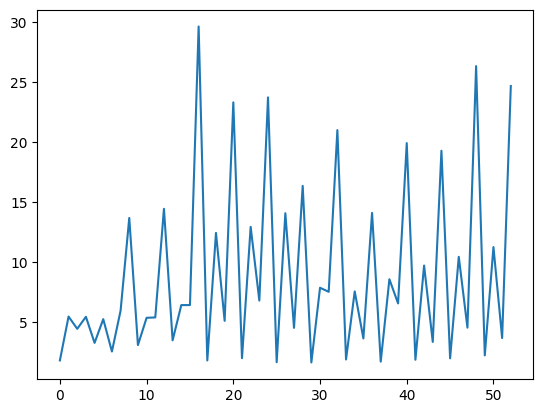

In [129]:
plt.plot(torch.linalg.matrix_norm(model.network.layers[0].weights, ord=1).detach().cpu())

[16, 8, 12, 14, 10, 13, 15, 9, 11, 7, 6, 5, 3, 1, 2, 4, 0]


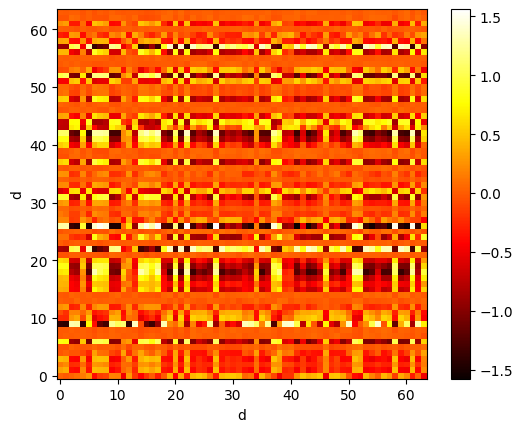

In [16]:
im = plt.imshow(model.network.layers[0].weights[16].detach().cpu(), cmap="hot", interpolation="nearest")
plt.xlabel("d")
plt.ylabel("d")
plt.gca().invert_yaxis()
plt.colorbar(im)

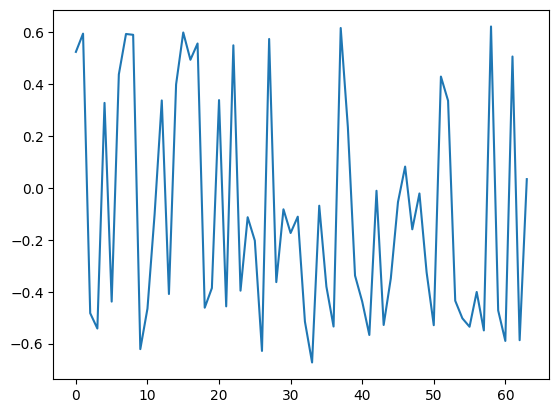

In [101]:
plt.plot(model.network.layers[0].weights[16, 40].detach().cpu())

# Zero-upshot super-resolution

In [51]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

def super_resolution(N1, N2, D, M):
    with fd.CheckpointFile(f"../../data/burgers/meshes/N{N2}.h5", "r") as file:
        mesh = file.load_mesh()
    
    
    model = BurgersModel.load(f"../../data/burgers/models/fourier/N{N1}/T1/D{D}_M{M}_samples1000_epoch500.pt", N1, "01", device)
    projection = ProjectionCoefficient.load(mesh, "burgers", N2, 1, M, "CG1", "fourier", device)
    
    for projection_layer in model.network.layers:
        projection_layer.coeff = projection.coeff
        projection_layer.coeff_T = projection.coeff.T
        projection_layer.functions = projection.functions
    
    
    data_path = f"../../data/burgers/samples/N{N2}_nu001_T1_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
    grid = torch.linspace(0, model.L, N2, device=device)
    trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
    testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
    
    mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1)/torch.norm(y, 2, dim=-1))
    
    optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
    
    network_trainer = NeuralNetworkTrainer(
        model,
        trainset,
        testset,
        mean_rel_l2_loss,
        optimizer,
        scheduler,
        max_epoch=500
    )
    
    with torch.no_grad():
        return network_trainer.test_epoch().detach().cpu().numpy()

/tmp/ipykernel_1760329/1006595774.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
/t

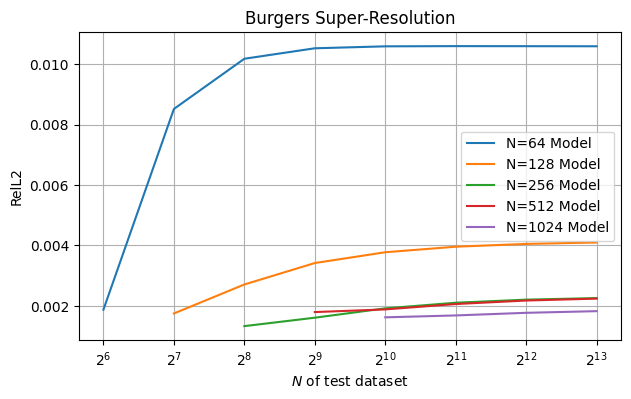

In [58]:
N2_range = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

D = 64
M = 16

plt.figure(figsize=(7, 4))
for i in range(5):
    N1 = N2_range[i]
    
    losses = []
    for N2 in N2_range[i:]:
        losses.append(super_resolution(N1, N2, D, M))

    plt.plot(N2_range[i:], losses, label=f"N={N1} Model")

plt.xscale("log", base=2)
plt.title("Burgers Super-Resolution")
# plt.xticks(N2_range)
plt.grid()
plt.ylabel("RelL2")
plt.xlabel("$N$ of test dataset")
plt.legend()